# Bicubic Interpolation Implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Define a function to display images

In [2]:
def show_img(img_arr, height, width):
    '''show the a height x width image using matplotlib'''

    # Convert the list into a numpy ndarray
    image = np.array(img_arr, dtype='uint8')
    # Convert the list to a height x width array
    image = np.reshape(image, (height, width))
    
    # Display the image using matplotlib
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.colorbar()  # Optional: shows a color scale bar
    plt.show()

## Read and display the image (from TSRI)

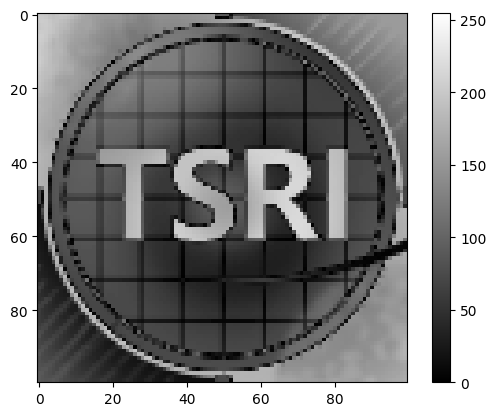

In [3]:
img_arr = []
with open('ImgROM.rcf', 'r') as file:
    for i, line in enumerate(file):
        if i == 100 * 100:
            break
        img_arr.append(int(line.strip(), 2))
show_img(img_arr, 100, 100)

## Read the patterns from file
- H0 : the horizontal coordinate of the top-left corner of the process region (0 <= H0 <= 99)
- V0 : the vertical coordinate of the top-left corner of the process region (0 <= V0 <= 99)
- SW : the width of the region in the horizontal direction of the process region (H0 + SW < 99)
- SH : the height of the region in the horizontal direction of the process region (V0 + SH < 99)
- TW : the horizontal width of the region processed by the Bicubic circuit after scaling (SW < TW < 2*SW)
- TH : the vertical height of the region processed by the Bicubic circuit after scaling (SH < TH < 2*SH)

In [4]:
info = []
ans = []
with open('pattern1', 'r') as file:
    for i, line in enumerate(file):
        # Pass the first line which is not required
        if i == 0: 
            pass
        # Read (H0, V0), (SW, SH), (TW, TH)
        elif 1 <= i <= 3: 
            line = line.strip().split()
            info.append(int(line[2]))
            info.append(int(line[3]))
        # Read the answers
        # There are two answers in a file
        # First half answers is for determine the calculation of interpolation2d which is compute the vertical interpolation first
        # Last half answers is for determine the calculation of interpolation2d which is compute the horizontal interpolation first
        else: 
            ans.append(int(line.strip()))
H0, V0, SW, SH, TW, TH = info
print(f"H0 = {H0}, V0 = {V0}\nSW = {SW}, SH = {SH}\nTW = {TW}, TH = {TH}")

H0 = 10, V0 = 68
SW = 13, SH = 13
TW = 19, TH = 19


## Define the interpolation1d and interpolation2d function to compute the scaling images

In [5]:
def interpolation1d(p_1, p0, p1, p2, x):
    a = (-1 * p_1 + 3 * p0 - 3 * p1 + p2) / 2
    b = (2* p_1 - 5 * p0 + 4 * p1 - p2) / 2
    c = (-1 * p_1 + p1) / 2 
    d = p0

    result = round(a * x * x * x + b * x * x + c * x + d)
    return result

def interpolation2d(p_1_1, p_10, p_11, p_12, 
                    p0_1, p00, p01, p02, 
                    p1_1, p10, p11, p12, 
                    p2_1, p20, p21, p22, 
                    x, y):
    
    p0 = interpolation1d(p0_1, p00, p01, p02, x)
    p1 = interpolation1d(p1_1, p10, p11, p12, x)
    p2 = interpolation1d(p2_1, p20, p21, p22, x)
    p_1 = interpolation1d(p_1_1, p_10, p_11, p_12, x)

    return interpolation1d(p_1, p0, p1, p2, y)

## Pre-compute the scaling coordinate x and y

In [6]:
x_new = [round(i*(SW-1)/(TW-1), 5) for i in range(TW)]
y_new = [round(i*(SH-1)/(TH-1), 5) for i in range(TH)]
print(x_new)
print(y_new)

[0.0, 0.66667, 1.33333, 2.0, 2.66667, 3.33333, 4.0, 4.66667, 5.33333, 6.0, 6.66667, 7.33333, 8.0, 8.66667, 9.33333, 10.0, 10.66667, 11.33333, 12.0]
[0.0, 0.66667, 1.33333, 2.0, 2.66667, 3.33333, 4.0, 4.66667, 5.33333, 6.0, 6.66667, 7.33333, 8.0, 8.66667, 9.33333, 10.0, 10.66667, 11.33333, 12.0]


In [7]:
# Convert 1d list into 2d
img = np.reshape(img_arr, (100, 100))

# Build the list for storing the scaling image
img_new = [ [0 for i in range(TW)] for i in range(TH)]

for i in range(TH):
    for j in range(TW):
        # compute the position
        idx_y = V0 + int(y_new[i])
        idx_x = H0 + int(x_new[j])
        if i == 0 or i == TH-1:
            # print('---- Type 1 ----')
            img_new[i][j] = interpolation1d(img[idx_y][idx_x-1], img[idx_y][idx_x], img[idx_y][idx_x+1], img[idx_y][idx_x+2], x_new[j]-int(x_new[j]))
        elif j == 0 or j == TW-1:
            # print('---- Type 2 ----')
            img_new[i][j] = interpolation1d(img[idx_y-1][idx_x], img[idx_y][idx_x], img[idx_y+1][idx_x], img[idx_y+2][idx_x], y_new[i]-int(y_new[i]))
        else:
            # print('---- Type 3 ----')
            img_new[i][j] = interpolation2d(img[idx_y-1][idx_x-1], img[idx_y-1][idx_x], img[idx_y-1][idx_x+1], img[idx_y-1][idx_x+2],
                                                img[idx_y][idx_x-1], img[idx_y][idx_x], img[idx_y][idx_x+1], img[idx_y][idx_x+2],
                                                img[idx_y+1][idx_x-1], img[idx_y+1][idx_x], img[idx_y+1][idx_x+1], img[idx_y+1][idx_x+2],
                                                img[idx_y+2][idx_x-1], img[idx_y+2][idx_x], img[idx_y+2][idx_x+1], img[idx_y+2][idx_x+2],
                                                x_new[j]-int(x_new[j]), y_new[i]-int(y_new[i]))
        # set pixel to 0 when it is less than 0
        if img_new[i][j] < 0:
            img_new[i][j] = 0

# Convert 2d list into 1d
my_ans = list(itertools.chain(*img_new))

## Compute the scaling image

## Comparision between my answer and the correct answer

In [8]:
def compare(ans, my_ans):
    error = 0
    for i in range(len(ans)//2):
        if ans[i] == my_ans[i] or ans[i+len(ans)//2] == my_ans[i]:
            # print('PASS !')
            pass
        else:
            error += 1
            print(f'ERROR! output={hex(my_ans[i])}, expected={hex(ans[i])}')
    if error == 0:
        print("PASS")
    else:
        print(f'total error = {error}')

In [9]:
compare(ans, my_ans)

PASS


## Display the scaling image

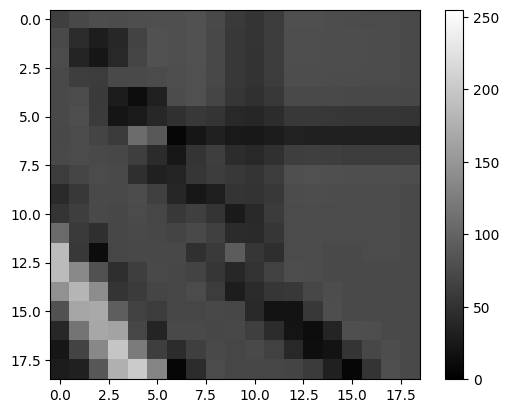

In [10]:
show_img(my_ans, TH, TW)